In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib_venn import venn3


import cooler
import bioframe

import cooltools
import cooltools.expected
from cooltools import snipping

import cooltools.lib.plotting
import multiprocess

from matplotlib.colors import LogNorm
from matplotlib.ticker import EngFormatter
bp_formatter = EngFormatter('b')
from scipy import interpolate
from mpl_toolkits.axes_grid import make_axes_locatable
import pyBigWig
import csv

from cooltools.lib.numutils import adaptive_coarsegrain, interp_nan
from cooltools.insulation import calculate_insulation_score, find_boundaries
from skimage.filters import threshold_li, threshold_otsu
import pyBigWig
from scipy import linalg
from scipy.signal import argrelextrema


cooltools.__version__

<ipython-input-1-21a864f9ab1d>:22: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid import make_axes_locatable


'0.4.0'

In [2]:
def format_ticks(ax, x=True, y=True, rotate=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)

def cgi_region(clr,region):
    cg = adaptive_coarsegrain(clr.matrix(balance=True).fetch(region),
                              clr.matrix(balance=False).fetch(region),
                              cutoff=3, max_levels=8)
    cgi = interp_nan(cg)
    return(cgi)

def bed3_mids(bed3plus,chrom,start,end):
    a = bed3plus[bed3plus['chrom']==chrom].reset_index()
    mid = (a['start']+a['end'])//2
    b = mid[(mid > start) & (mid < end)]
    return(np.array(b))

def bed3_mids2(bed3plus,chrom,start,end):
    a = bed3plus[bed3plus['chrom']==chrom].reset_index(drop=True)
    mid = (a['start']+a['end'])//2
    b = a[(mid > start) & (mid < end)].iloc[:,[0,1,2]]
    return(b.reset_index(drop=True))

def add_mid(input):
    input['chrom']=input['chrom'].str.replace('chr','')
    input['mid']=(input.end+input.start)//2
    return input

def add_windows(input,region):
    w = snipping.make_bin_aligned_windows(
        resolution,
        input['chrom'],input['mid'],flank_bp=flank)
    w['strand']='.'
#    w['region'] = ce10_X['name'][0]
    w = snipping.assign_regions(w, region)
    return w

nthreads=4
def my_pup_clr(clr,windows,regions):
    clr_snipper = cooltools.snipping.CoolerSnipper(clr, regions=regions)
    with multiprocess.Pool(nthreads) as pool:
        clr_stack = cooltools.snipping.pileup(
            windows,
            clr_snipper.select,
            clr_snipper.snip,
            map=pool.map
            )
    clr_avg = np.nanmean(clr_stack, axis=2)
    return clr_avg

def my_expected(clr,regions):
    with multiprocess.Pool(nthreads) as pool:
        expected = cooltools.expected.diagsum(
            clr,
            regions=regions,
            transforms={
                'balanced': lambda p: p['count'] * p['weight1'] * p['weight2']
            },
            map=pool.map
        )
    expected['balanced.avg'] = expected['balanced.sum'] / expected['n_valid']
    return(expected)

def my_pup_oe(clr,windows,regions,expected):
    expected_snipper = cooltools.snipping.ObsExpSnipper(clr, expected, regions=regions)
    with multiprocess.Pool(nthreads) as pool:
        oe_stack = cooltools.snipping.pileup(
            windows,
            expected_snipper.select,
            expected_snipper.snip,
            map=pool.map
        )
    expected_avg = np.nanmean(oe_stack, axis=2)
    return expected_avg

def bwTobedMatrix(bw,region,nbins):
    lst_region = [region['start'],region['end']]
    lst_bw = []
    for i in range(0,len(lst_region[0])):
        chrom = "".join(['chr', region['chrom'][i]]) # bw uses 'chrI', my bed uses 'I'
        if lst_region[1].reset_index(drop=True)[i] < bw.chroms(chrom):
            if lst_region[0].reset_index(drop=True)[i] > 0:
                v = bw.stats(chrom,
                             lst_region[0].reset_index(drop=True)[i],
                             lst_region[1].reset_index(drop=True)[i],
                             type='mean',nBins=nbins)
            
                lst_bw.append(pd.to_numeric(v,errors='coerce'))
    return(lst_bw)

def InsLocalMax(coolr, windowSize, method):
    x = calculate_insulation_score(coolr, windowSize, verbose=False)
    val = x["log2_insulation_score_"+str(windowSize)].apply(lambda x: x*-1)
    
    x_1 = x[['chrom','start','end','is_bad_bin',"n_valid_pixels_"+str(windowSize)]]
    x_2 = pd.concat([x_1,val],axis=1).reindex(x_1.index)
    y = find_boundaries(x_2,log2_ins_key="log2_insulation_score_"+str(windowSize),
                        n_valid_pixels_key="n_valid_pixels_"+str(windowSize))
    
    if method=='otsu':
        print('otsu')
        t = threshold_otsu(y['boundary_strength'].dropna().values)
    if method =='li':
        print('li')
        t = threshold_li(y['boundary_strength'].dropna().values)
    t_1 = y[y['boundary_strength']>t]    
    print(len(t_1.index))    
    return y,t_1


def InsLocalMax_ofdiff_AminusB(coolrA,coolrB, windowSize, method):
    a = calculate_insulation_score(coolrA, windowSize, verbose=False)
    b = calculate_insulation_score(coolrB, windowSize, verbose=False)
    diff = b[["log2_insulation_score_"+str(windowSize)]]-a[["log2_insulation_score_"+str(windowSize)]]
    a_1 = a[['chrom','start','end','is_bad_bin',"n_valid_pixels_"+str(windowSize)]]
    a_2 = pd.concat([a_1, diff], axis=1).reindex(a_1.index)
    y = find_boundaries(a_2,log2_ins_key="log2_insulation_score_"+str(windowSize),
                        n_valid_pixels_key="n_valid_pixels_"+str(windowSize))
    
    if method=='otsu':
        print('otsu')
        t = threshold_otsu(y['boundary_strength'].dropna().values)
    if method =='li':
        print('li')
        t = threshold_li(y['boundary_strength'].dropna().values)
    t_1 = y[y['boundary_strength']>t]    
    print(len(t_1.index))
    return y,t_1

def QuantilesPandas(dat,Colname):
    boundaryS = dat[Colname]
    q1 = np.quantile(boundaryS,0.25)
    q2 = np.quantile(boundaryS,0.5)
    q3 = np.quantile(boundaryS,0.75)
    #print(q1,q2,q3)
    grp1 = dat[boundaryS<q1]
    grp2 = dat[np.logical_and(boundaryS>=q1, boundaryS<q2)]
    grp3 = dat[np.logical_and(boundaryS>=q2, boundaryS<q3)]
    grp4 = dat[boundaryS>=q3]
    return grp1,grp2,grp3,grp4


def scaling_agg(input_clr,input_regions):
    cvd = cooltools.expected.diagsum(
        clr=input_clr,
        regions=input_regions,
        transforms={'balanced': lambda p: p['count']*p['weight1']*p['weight2']}
    )
    lb_cvd, lb_slopes, lb_distbins = cooltools.expected.logbin_expected(cvd)
    lb_cvd_agg, lb_slopes_agg = cooltools.expected.combine_binned_expected(
        lb_cvd,
        binned_exp_slope=lb_slopes
    )
    lb_cvd_agg['s_bp'] = lb_cvd_agg['diag.avg'] * input_clr.binsize
    lb_slopes_agg['s_bp'] = lb_slopes_agg['diag.avg'] * input_clr.binsize
    x = np.array(lb_slopes_agg['s_bp'])
    y = np.array(lb_slopes_agg['slope'])
    loop_size = x[argrelextrema(y, np.greater)]
    LocalMins = x[argrelextrema(y, np.less)]
    return(lb_cvd_agg,lb_slopes_agg,loop_size,LocalMins)


In [3]:
ce10=bioframe.read_table('/home/kimj50/ce10.chrom.sizes',schema='bed3')
ce10=bioframe.parse_regions(ce10)


INFO:numexpr.utils:Note: NumExpr detected 48 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [9]:
# clrs
res = '500'
clr_notag = cooler.Cooler("/scratch/cgsb/ercan/juicerToh5_2021/hicTocool_raw/JK07_JK08_30_"+res+"_raw.cool")
clr_smc3 = cooler.Cooler("/scratch/cgsb/ercan/juicerToh5_2021/hicTocool_raw/JK153_JK180_30_"+res+"_raw.cool")
clr_wapl = cooler.Cooler("/scratch/cgsb/ercan/juicerToh5_2021/hicTocool_raw/JK155_combined_JK181_30_"+res+"_raw.cool")

clrs = [clr_notag,clr_smc3,clr_wapl]

In [13]:
#### insulation, use bw

windows = [30000]

clrs
clrs_ins = []
for i in range(len(clrs)):
    x = calculate_insulation_score(clrs[i], windows, verbose=True)
    clrs_ins.append(x)

INFO:root:Processing I
INFO:root:Processing II
INFO:root:Processing III
INFO:root:Processing IV
INFO:root:Processing V
INFO:root:Processing X
INFO:root:Processing I
INFO:root:Processing II
INFO:root:Processing III
INFO:root:Processing IV
INFO:root:Processing V
INFO:root:Processing X
INFO:root:Processing I
INFO:root:Processing II
INFO:root:Processing III
INFO:root:Processing IV
INFO:root:Processing V
INFO:root:Processing X


In [14]:
#### add chr and write insulation as bedgraph then convert to bigwig using bgtobigwig ####
def insulation_to_bedgraph(Cooler_insulation, W):
#    Ins = Cooler_insulation[Cooler_insulation['is_bad_bin']==False]
    Ins = Cooler_insulation
    a = Ins[['chrom','start','end','log2_insulation_score_'+str(W)]]
    a['chrom'] = 'chr'+a['chrom'].astype(str)
    b = a.dropna()
    print(len(a),len(b))
    return b

ins_bg = []
for i in range(len(clrs_ins)):
    t = insulation_to_bedgraph(clrs_ins[i],30000)
    ins_bg.append(t)

#ins_bg[0].to_csv('/home/kimj50/cohesin_paper/_notebook_v1/output/CA1200_HiC500b_W30kb_insulation.bg',sep='\t',header=False,index=False)
#ins_bg[1].to_csv('/home/kimj50/cohesin_paper/_notebook_v1/output/JK05_HiC500b_W30kb_insulation.bg',sep='\t',header=False,index=False)
#ins_bg[2].to_csv('/home/kimj50/cohesin_paper/_notebook_v1/output/JK06_HiC500b_W30kb_insulation.bg',sep='\t',header=False,index=False)



200547 199785
200547 199782
200547 199782


<ipython-input-14-42a47646df11>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['chrom'] = 'chr'+a['chrom'].astype(str)
<ipython-input-14-42a47646df11>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['chrom'] = 'chr'+a['chrom'].astype(str)
<ipython-input-14-42a47646df11>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

In [15]:
# bws 
bw_smc1_ca1200 = pyBigWig.open("/home/kimj50/cohesin_paper/SMC1_SMC3_chips/SMC1_Q4467_CA1200_1hrauxin_ext663_ext664_inputsubt_avgFIX.bw")
bw_smc1_jk05 = pyBigWig.open("/home/kimj50/cohesin_paper/SMC1_SMC3_chips/SMC1_Q4467_JK05_1hrauxin_ext661_ext662_inputsubt_avgFIX.bw")
bw_smc1_jk06 = pyBigWig.open("/home/kimj50/cohesin_paper/SMC1_SMC3_chips/SMC1_Q4467_JK06_1hrauxin_ext639_ext673_inputsubt_avgFIX.bw")

bw_smc3_ca1200 = pyBigWig.open("/home/kimj50/cohesin_paper/SMC1_SMC3_chips/SMC3_Q4469_CA1200_1hrauxin_ext663_ext664_inputsubt_avgFIX.bw")
bw_smc3_jk05 = pyBigWig.open("/home/kimj50/cohesin_paper/SMC1_SMC3_chips/SMC3_Q4469_JK05_1hrauxin_ext661_ext662_inputsubt_avgFIX.bw")
bw_smc3_jk06 = pyBigWig.open("/home/kimj50/cohesin_paper/SMC1_SMC3_chips/SMC3_Q4469_JK06_1hrauxin_ext639_ext673_inputsubt_avgFIX.bw")

bw_ins_ca1200 = pyBigWig.open("/home/kimj50/cohesin_paper/_notebook_v1/output/CA1200_HiC500b_W30kb_insulation.bw")
bw_ins_jk05 = pyBigWig.open("/home/kimj50/cohesin_paper/_notebook_v1/output/JK05_HiC500b_W30kb_insulation.bw")
bw_ins_jk06 = pyBigWig.open("/home/kimj50/cohesin_paper/_notebook_v1/output/JK06_HiC500b_W30kb_insulation.bw")


In [10]:
#### expected for center region
center = bioframe.read_table('/scratch/cgsb/ercan/Jun_annot/center.txt',schema='bed3')
print(center)

clrs_exp_center = []
for i in range(len(clrs)):
    exp_centers = []
#    for j in range(len(center)):
    for j in range(1):
        print(i,j)
        x = my_expected(clrs[i],center.iloc[[j]].reset_index())
        exp_centers.append(x)        
    clrs_exp_center.append(exp_centers)

#### expected for left
left = bioframe.read_table('/scratch/cgsb/ercan/Jun_annot/arms_left.txt',schema='bed3')
print(left)

#clrs_exp_left = []
#for i in range(len(clrs)):
#    exp_left = []
#    for j in range(len(left)):
#        x = my_expected(clrs[i],left.iloc[[j]].reset_index())
#        exp_left.append(x)       
#    clrs_exp_left.append(exp_left)

#### expected for right
right = bioframe.read_table('/scratch/cgsb/ercan/Jun_annot/arms_right.txt',schema='bed3')
print(right)

#clrs_exp_right = []
#for i in range(len(clrs)):
#    exp_right = []
#    for j in range(len(right)):
#        x = my_expected(clrs[i],right.iloc[[j]].reset_index())
#        exp_right.append(x)
#        clrs_exp_right.append(exp_right)

  chrom    start       end
0     I  4640000  10120000
1    II  4690000  11880000
2   III  4310000   9865000
3    IV  6740000  12050000
4     V  8170000  13830000
5     X  4050000  15750000
0 0
1 0
2 0
  chrom  start      end
0     I      0  4640000
1    II      0  4690000
2   III      0  4310000
3    IV      0  6740000
4     V      0  8170000
5     X      0  4050000
  chrom     start       end
0     I  10120000  15072422
1    II  11880000  15279344
2   III   9865000  13783699
3    IV  12050000  17493792
4     V  13830000  20924148
5     X  15750000  17718865


I:5242000-5352000
[5315000]
[5315000]
[5315000]


<ipython-input-11-7022b8fd32d0>:252: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


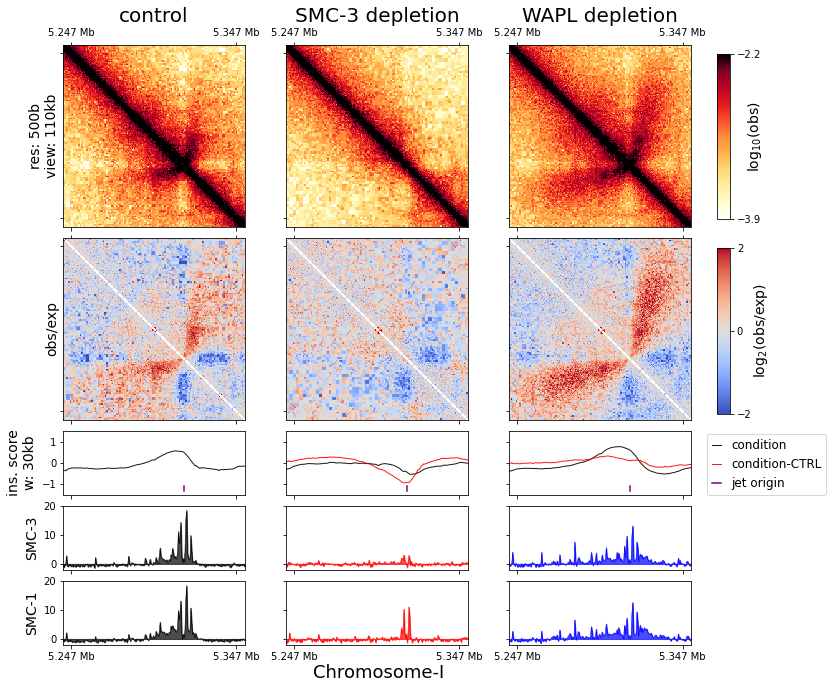

In [11]:
# plot # but use insulation bigwig, not computed insulation
np.seterr(invalid='ignore')

ndat = len(clrs)
bws0 = [bw_ins_ca1200,bw_ins_jk05,bw_ins_jk06]
bws1 = [bw_smc3_ca1200,bw_smc3_jk05,bw_smc3_jk06]
bws2 = [bw_smc1_ca1200,bw_smc1_jk05,bw_smc1_jk06]
jets_annot = bioframe.read_table('/home/kimj50/cohesin_paper/jets_call/jetcall_v5_w30kb.bed',schema='bed4')
##
##
clrs_ins_w = 30_000

#sub_titles = ['No-tag auxin','smc3-deg auxin','wapl-deg auxin']
sub_titles = ['control','SMC-3 depletion','WAPL depletion']
f, axs = plt.subplots(
    figsize=(10, 10),
    nrows=1,
    ncols=ndat,
    sharex='col',
    sharey='row'
)

obs = [-3.9,-2.2]
obsexp = [-2,2]

bw_min1, bw_max1 = [-2.,20]
bw_min2, bw_max2 = [-2.,20]
ins_min, ins_max = [-1.5,1.5]
cond_colors = ['black','red','blue']

pad_param = 0.16
signalsize = "35%"


############################################## plot region ############################################

##### region 1 - main figure, left tilted #####
chrom = 'I'
start, end = 5_242_000, 5_352_000
clrs_exp_region = clrs_exp_center




#### region 2 - right tilted ####
#chrom = 'V'
#start,end = 6_168_000,6_330_000
#clrs_exp_region = clrs_exp_left

#### region 3 - doublet stripe ####
#chrom = 'III'
#start,end = 12_430_000,12_750_000
#clrs_exp_region = clrs_exp_right

#### region 4 - kink ####
#chrom = 'I'
#start,end = 9_320_000,9_438_000
#clrs_exp_region = clrs_exp_center

#### region 5 - broadloading ###
#chrom = 'II'
#start,end = 10_480_000,10_620_000
#clrs_exp_region = clrs_exp_center

#### region 6 - jet X 1 ####
#chrom = 'X'
#start,end = 6_675_000,6_805_000
#clrs_exp_region = clrs_exp_center

#### region 7 - jet X byrex ####
#chrom = 'X'
#start,end = 7_935_000,8_115_000
#clrs_exp_region = clrs_exp_center

#### region 8 - favorite ####
#chrom = 'X'
#start,end = 15_850_000, 16_850_000
#clrs_exp_region = clrs_exp_right
#obs = [-4.7,-2.2]
#obsexp = [-1.5,1.5]

#start,end = 5_497_390,5_766_611

#start,end = 8_590_410,8_730_853

#############################################################################
region = chrom+':'+str(start)+'-'+str(end)
print(region)
if chrom=='I':
    chrn=0
elif chrom=='II':
    chrn=1
elif chrom=='III':
    chrn=2
elif chrom=='IV':
    chrn=3
elif chrom=='V':
    chrn=4
elif chrom=='X':
    chrn=5
###########################################################################



extents = (start, end, end, start)
Alpha = 0.7
lineWidth = 0.5
bigFont = 14
smallFont = 11
titlefont = 20
tickpad = 5_000
ticks = [start+tickpad,end-tickpad]
#ticks = [,end]
wView = (end-start)//1000
yLabs = ['res: '+str(int(res))+'b\nview: '+str(wView)+'kb','obs/exp',
         'ins. score\nw: '+str(clrs_ins_w//1000)+'kb','SMC-3', 'SMC-1']



for i in range(len(clrs)):
    ax = axs[i]
    clr_region = cgi_region(clrs[i],region)
    im = ax.matshow(
        np.log10(clr_region),
        cmap='fall',
        vmin=obs[0],vmax=obs[1],
        extent=extents
    )
    divider = make_axes_locatable(ax)
    format_ticks(ax,rotate=False)
    ax.set_title(sub_titles[i],fontsize=titlefont)
    ax.tick_params(axis="x", bottom=True, top=True, labelbottom=False, labeltop=False)

###########    
    ax_oe = divider.append_axes("bottom", size='100%', pad=pad_param)
    obs_exp = clr_region/linalg.toeplitz(clrs_exp_region[i][chrn]['balanced.avg'][0:len(clr_region)])   
    im_oe = ax_oe.matshow(
        np.log2(obs_exp),
        cmap='coolwarm',
        vmin=obsexp[0],vmax=obsexp[1],
        extent=extents
    )
    format_ticks(ax_oe,rotate=False)
    ax_oe.tick_params(axis="x", bottom=True, top=True, labelbottom=False, labeltop=False)
    
########### ins ##############    
    ax1 = divider.append_axes("bottom", size=signalsize, pad=pad_param)
    
    bw_region = bws0[i].stats('chr'+chrom,start,end,type="mean",nBins=len(clr_region))
    xval = np.linspace(start, end, len(clr_region))
    yval = np.array(bw_region, dtype=float)
    mask = np.isfinite(yval)
    ax1.plot(
        xval[mask],
        yval[mask],
        lw=1,color='black', alpha=0.9, label='condition')
    if i > 0:
        bw_region0 = bws0[0].stats('chr'+chrom,start,end,type="mean",nBins=len(clr_region))
        yval0 = np.array(bw_region0, dtype=float)
        ax1.plot(xval[mask],
                 np.subtract(yval[mask],yval0[mask]),
                 lw=1,color='red',alpha=0.9, label='condition-CTRL')
    ax1.set_ylim(ins_min,ins_max)
    plt.xlim([xval.min(), xval.max()])
    
    
######### annot ##########
    jets_annot_1 = bed3_mids(jets_annot,chrom,start,end)
    print(jets_annot_1)
    for a in range(len(jets_annot_1)):
        ax1.axvline(x=jets_annot_1[a],ymin=0.05,ymax=0.13,c="purple",alpha=1,label='jet origin')



######## cohesin chip 1 ######
    ax2 = divider.append_axes("bottom", size=signalsize, pad=pad_param)
    bw_region = bws1[i].stats('chr'+chrom,start,end,type="mean",nBins=len(clr_region))
    xval = np.linspace(start, end, len(clr_region))
    yval = np.array(bw_region, dtype=float)
    mask = np.isfinite(yval)
    ax2.plot(
        xval[mask],
        yval[mask],lw=lineWidth,color=cond_colors[i])
    plt.fill_between(xval[mask],0,yval[mask],interpolate=False,alpha=Alpha,color=cond_colors[i])

    ax2.set_ylim([bw_min1,bw_max1])
    plt.xlim([xval.min(), xval.max()])

######## cohesin chip 2 ######
    ax3 = divider.append_axes("bottom", size=signalsize, pad=pad_param)
    bw_region = bws2[i].stats('chr'+chrom,start,end,type="mean",nBins=len(clr_region))
    xval = np.linspace(start, end, len(clr_region))
    yval = np.array(bw_region, dtype=float)
    mask = np.isfinite(yval)
    ax3.plot(
        xval[mask],
        yval[mask],lw=lineWidth,color=cond_colors[i])
    plt.fill_between(xval[mask],0,yval[mask],interpolate=False,alpha=Alpha,color=cond_colors[i])

    ax3.set_ylim([bw_min2,bw_max2])
    plt.xlim([xval.min(), xval.max()])

#### y-axis #### 
    if i == 0:
        ax.set_ylabel(yLabs[0],fontsize=bigFont)
        ax_oe.set_ylabel(yLabs[1],fontsize=bigFont)
        ax1.set_ylabel(yLabs[2],fontsize=bigFont)
        ax2.set_ylabel(yLabs[3],fontsize=bigFont)
        ax3.set_ylabel(yLabs[4],fontsize=bigFont)
    if i > 0:
        ax1.set_yticklabels([])
        ax2.set_yticklabels([])
        ax3.set_yticklabels([])
    
#### x-axis ####
    format_ticks(ax3,x=True,y=False,rotate=False)
    ax.tick_params(axis="both", bottom=True, top=True, labelbottom=False, labeltop=True,labelleft=False)
    ax_oe.tick_params(axis="both", bottom=True, top=True, labelbottom=False, labeltop=False,labelleft=False)
    ax1.tick_params(axis="x",labelbottom=False)
    ax2.tick_params(axis="x",labelbottom=False)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax_oe.set_xticks(ticks)
    ax_oe.set_yticks(ticks)
    ax1.set_xticks(ticks)
    ax2.set_xticks(ticks)
    ax3.set_xticks(ticks)

## legend ##
handles, labels = ax1.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
leg = f.legend(by_label.values(), by_label.keys(),bbox_to_anchor=(1.16, 0.37),prop={'size': 12},
               handlelength=0.8)
leg._legend_box.align = "left"
    

## cbar obs ##
cbaxes = f.add_axes([1, .66, 0.018, 0.23])
cbar = plt.colorbar(im, cax = cbaxes,ticks=[obs[0],obs[1]])
cbar.ax.get_yaxis().labelpad = 2
cbar.ax.set_ylabel('$\log_{10}$(obs)', rotation=90,fontsize=bigFont,labelpad=-15)

## cbar obs/exp ##
cbaxes = f.add_axes([1, .39, 0.018, 0.23])
cbar = plt.colorbar(im_oe, cax = cbaxes,ticks=[obsexp[0],0,obsexp[1]])
cbar.ax.get_yaxis().labelpad = 2
cbar.ax.set_ylabel('$\log_{2}$(obs/exp)', rotation=90,fontsize=bigFont,labelpad=0)


f.text(0.53, 0.023, 'Chromosome-'+chrom, ha='center',fontsize=bigFont+4)

plt.tight_layout()